In [ ]:
###########################################################################################################
#                                                 IN THE NAME OF ALLAH                                    #
#               Dynamic Response Analysis of Single-degree-of-freedom (SDOF) damped system                #
#                                     subjected to harmonic loading using OpenSees                        #
#  and evaluates its time-history behavior, response factors and transmissibility for harmonic excitation #
#---------------------------------------------------------------------------------------------------------# 
#                            THIS PROGRAM IS WRITTEN BY SALAR DELAVAR GHASHGHAEI (QASHQAI)                #
#                                          EMAIL: SALAR.D.GHASHGHAEI@GMAIL.COM                            #
###########################################################################################################

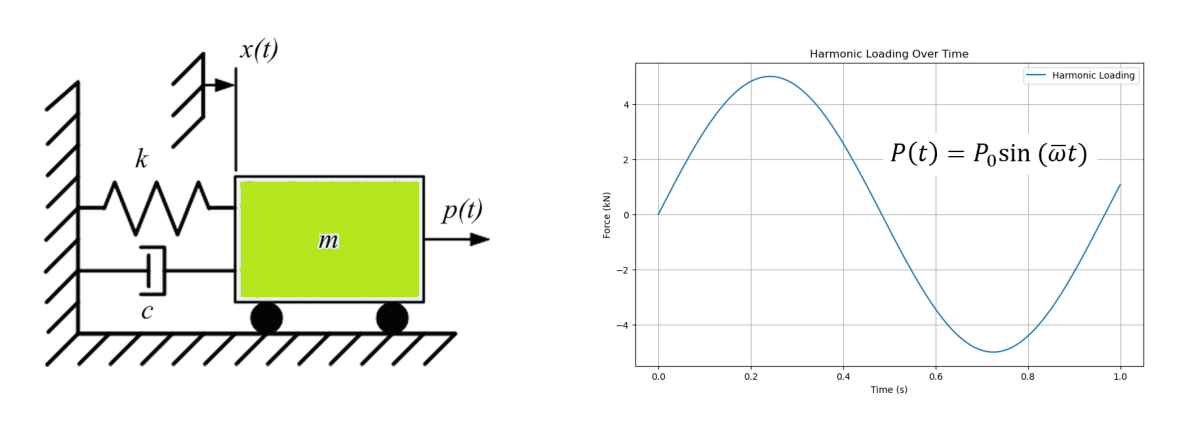

In [1]:
# Load the image
def PLOT_IMAGE(image):
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    image = mpimg.imread(image_path)

    # Display the image
    plt.figure(figsize=(15, 8))
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()
    
image_path = 'OPENSEES_HARMONIC_LAODING.png'    
PLOT_IMAGE(image_path)

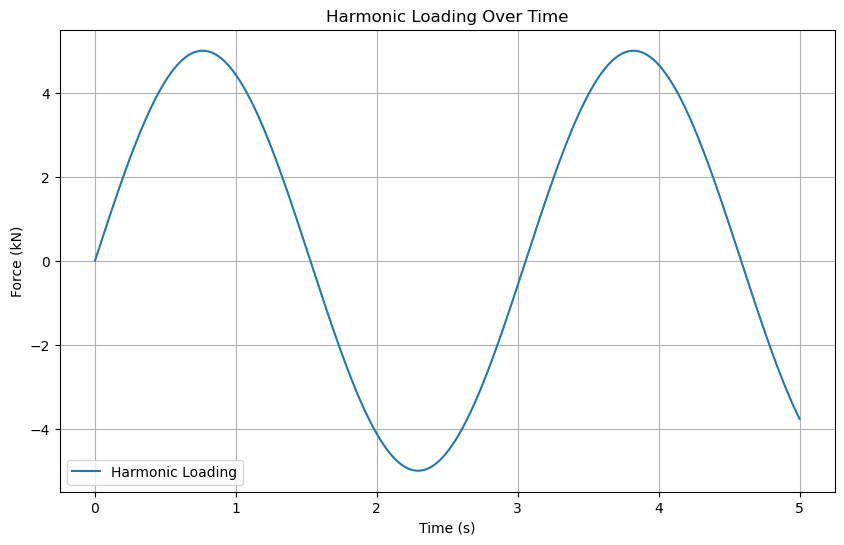

In [2]:
"""
Key points:
1. System Parameters: The mass, stiffness, and natural frequency of the system are defined, along with a range of damping ratios for analysis.
2. Response Factor Calculation: For 10 damping ratios, the deformation, velocity, and acceleration response factors are computed analytically over a range of excitation frequency ratios.
3. Harmonic Loading: A sinusoidal force with a specified frequency and amplitude is applied as external excitation.
4. OpenSees Model: Nodes, mass, stiffness, and Rayleigh damping are defined, enabling transient analysis for time-history response.
5. Time History Simulation: The system's displacement, velocity, acceleration, and base reactions are simulated over a defined time span.
6. Harmonic Force Visualization: The applied harmonic force is plotted over time.
7. Time History Results: Displacement, velocity, acceleration, and base reaction time histories are plotted to illustrate transient response.
8. Analysis Insights: The code evaluates system behavior under various damping conditions and external forcing scenarios.
9. Visual Representation: Comprehensive plots provide insights into both steady-state and transient behaviors of the damped SDOF system.
10. Plotting: Response factors (deformation, velocity, acceleration) are plotted against frequency ratios for different damping ratios.
11. Plotting: Transmissibility for harmonic excitation. Force transmissibility and ground motion transmissibility
"""
import openseespy.opensees as ops
import numpy as np
import matplotlib.pyplot as plt

# System parameters
mass = 10.0         # Mass (ton)
stiffness = 100.0  # Stiffness (kN/m)
omega_n = np.sqrt(stiffness / mass)  # Natural angular frequency (rad/s)

# Define the OpenSees model
ops.wipe()
ops.model('Basic', '-ndm', 1, '-ndf', 1)

# Define nodes
ops.node(1, 0.0)  # Fixed node
ops.node(2, 0.0)  # Moving node

# Define boundary conditions
ops.fix(1, 1)

# Define mass
ops.mass(2, mass)

# Define spring element
ops.uniaxialMaterial('Elastic', 1, stiffness)
ops.element('zeroLength', 1, 1, 2, '-mat', 1, '-dir', 1)

# Time history analysis for a specific damping ratio
zeta = 0.05 # Damping Ratio
ops.rayleigh(0.0, 0.0, 2 * zeta * omega_n, 0.0)

dt = 0.01  # Time step
total_time = 50.0
num_steps = int(total_time / dt)
force_time = np.linspace(0, 0.1 * total_time, num_steps) # Force time 10 is percent of total time

target_frequency = 0.65 * omega_n  # Target excitation frequency
force_amplitude = 5.0
force = force_amplitude * np.sin(target_frequency * force_time)

# Plot harmonic loading
plt.figure(figsize=(10, 6))
plt.plot(force_time, force, label='Harmonic Loading')
plt.title('Harmonic Loading Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Force (kN)')
plt.grid(True)
plt.legend()
plt.show()

# Apply force time series
ops.timeSeries('Path', 1, '-dt', dt, '-values', *force)
ops.pattern('Plain', 1, 1)
ops.load(2, 1.0)  # Apply load to moving node

# Analysis setup
ops.constraints('Plain')
ops.numberer('Plain')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-8, 10)
ops.integrator('Newmark', 0.5, 0.25)
ops.algorithm('Newton')
ops.analysis('Transient')

# Time history results
time_history_displacement = []
time_history_velocity = []
time_history_acceleration = []
time_history_base_reaction = []
time_history_time = []

# Perform time history analysis
for step in range(num_steps):
    ops.analyze(1, dt)
    disp = ops.nodeDisp(2, 1)
    vel = ops.nodeVel(2, 1)
    accel = ops.nodeAccel(2, 1)
    reaction = -stiffness * disp  # Base reaction

    time_history_displacement.append(disp)
    time_history_velocity.append(vel)
    time_history_acceleration.append(accel)
    time_history_base_reaction.append(reaction)
    time_history_time.append(step * dt)

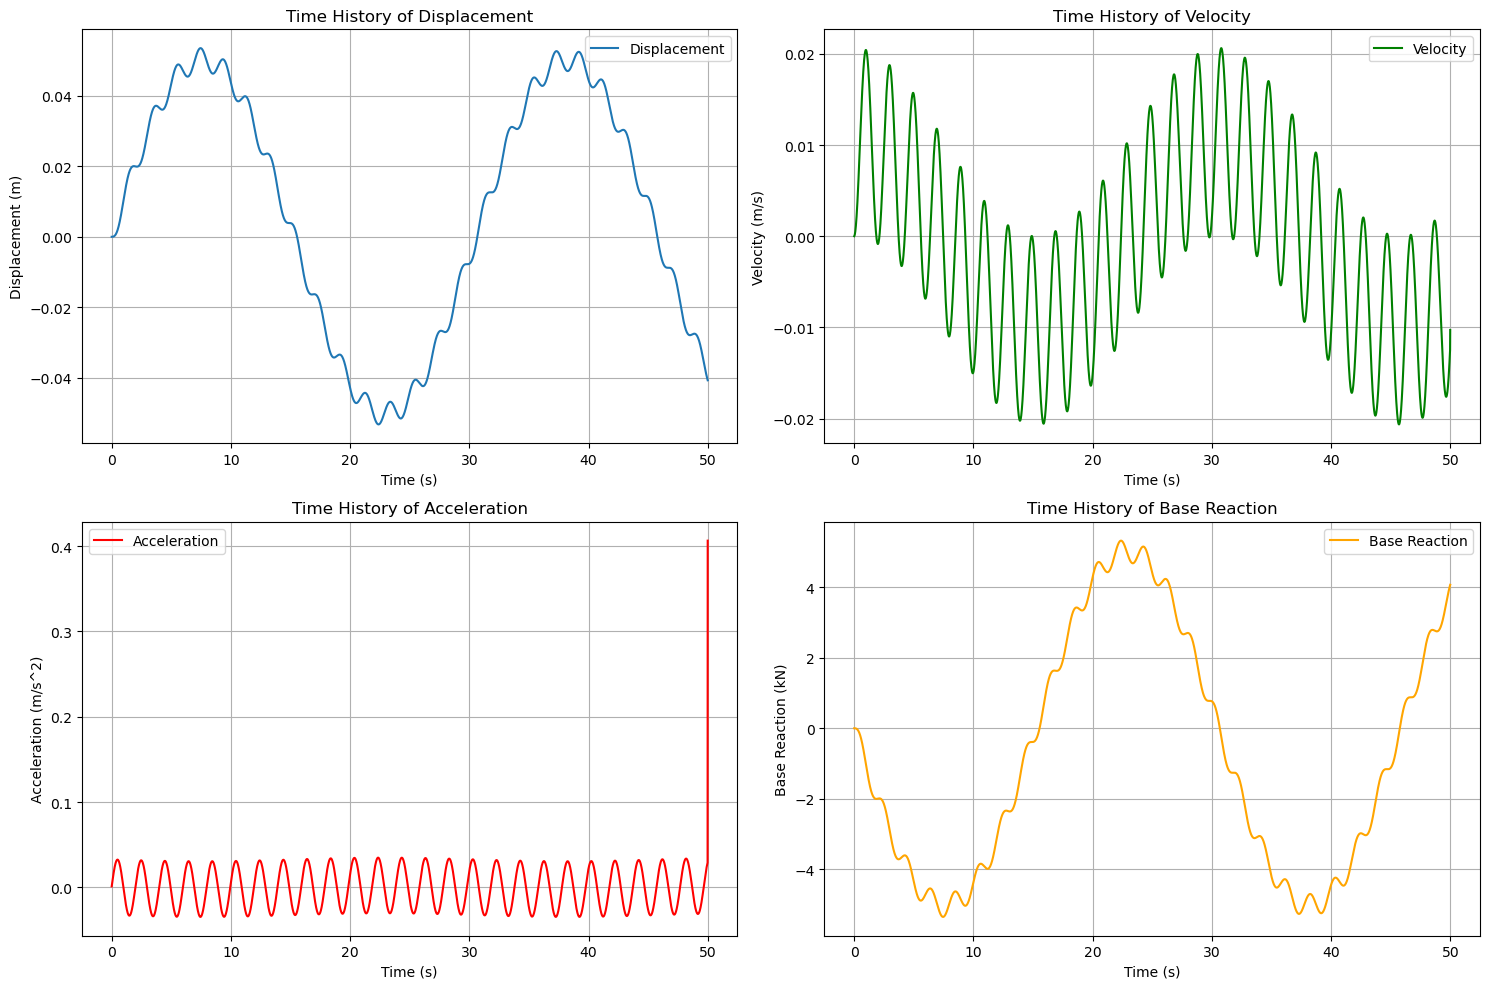

In [3]:
# Plot time history results
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(time_history_time, time_history_displacement, label='Displacement')
plt.title('Time History of Displacement')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(time_history_time, time_history_velocity, label='Velocity', color='g')
plt.title('Time History of Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(time_history_time, time_history_acceleration, label='Acceleration', color='r')
plt.title('Time History of Acceleration')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(time_history_time, time_history_base_reaction, label='Base Reaction', color='orange')
plt.title('Time History of Base Reaction')
plt.xlabel('Time (s)')
plt.ylabel('Base Reaction (kN)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

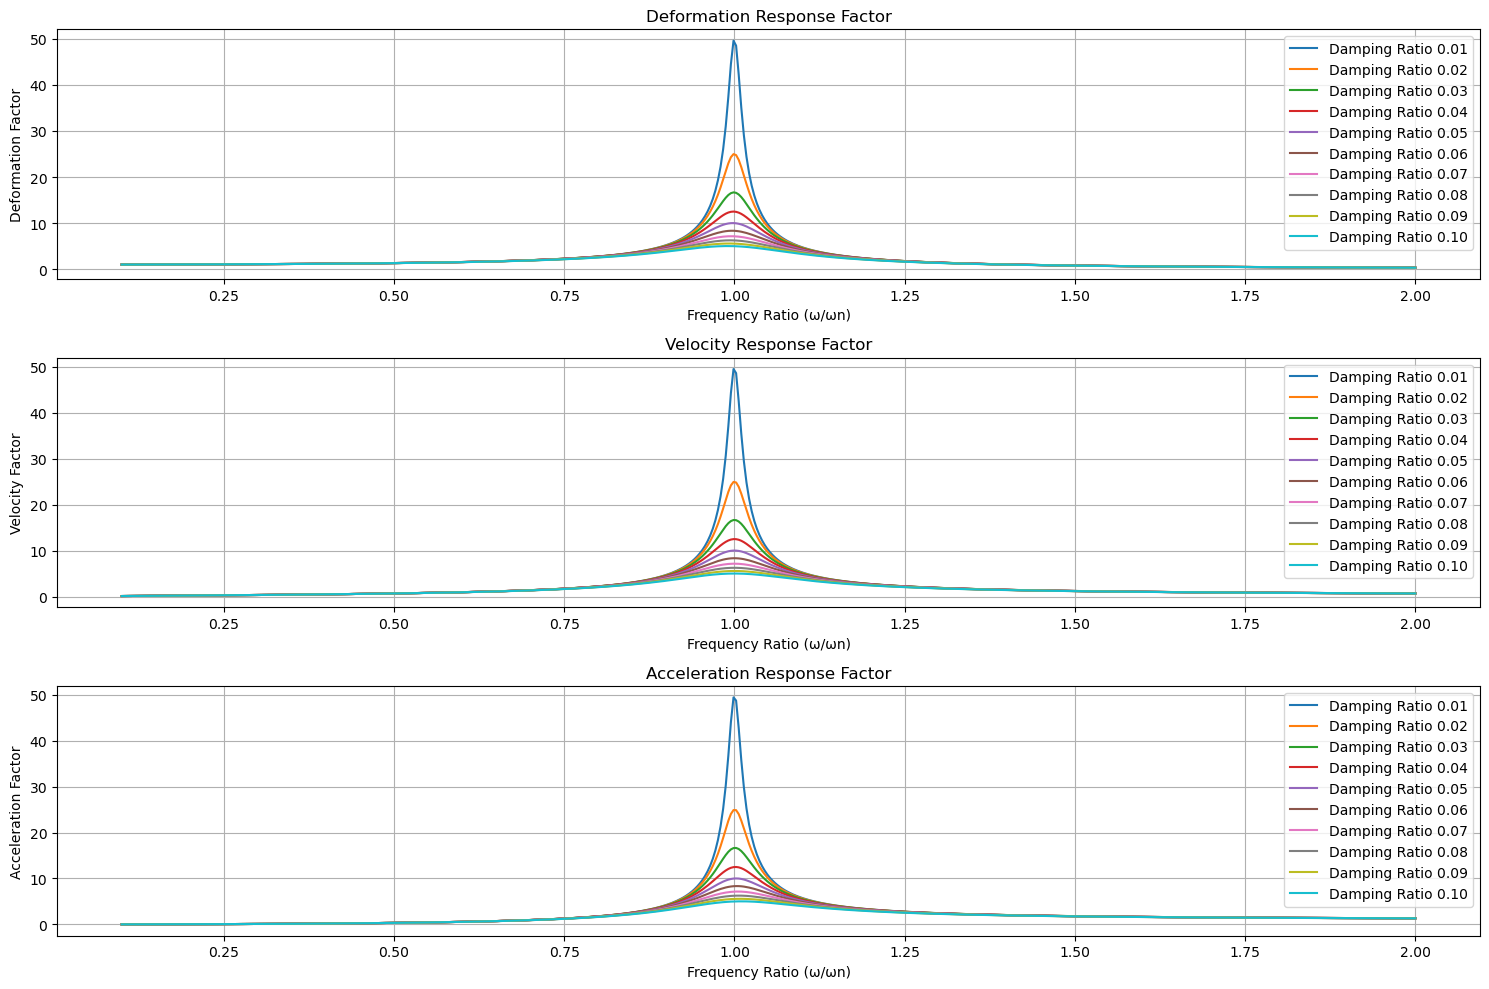

In [5]:
# Damping ratios to evaluate
damping_ratios = np.linspace(0.01, 0.1, 10)  # 10 damping ratios between 0.01 and 0.1

# Harmonic excitation
frequency_ratios = np.linspace(0.1, 2.0, 500)  # Excitation frequency ratios (omega / omega_n)

# Storage for response factors
response_factors_deformation = []
response_factors_velocity = []
response_factors_acceleration = []

# Loop over damping ratios
for zeta in damping_ratios:
    # Define Rayleigh damping
    ops.rayleigh(0.0, 0.0, 2 * zeta * omega_n, 0.0)

    deformation_factors = []
    velocity_factors = []
    acceleration_factors = []

    # Loop over frequency ratios
    for r in frequency_ratios:
        omega_excitation = r * omega_n

        # Response factor formulas
        denominator = np.sqrt((1 - r**2)**2 + (2 * zeta * r)**2)
        deformation_factors.append(1 / denominator)
        velocity_factors.append(r / denominator)
        acceleration_factors.append(r**2 / denominator)

    response_factors_deformation.append(deformation_factors)
    response_factors_velocity.append(velocity_factors)
    response_factors_acceleration.append(acceleration_factors)
    
# Plot response factors
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
for i, zeta in enumerate(damping_ratios):
    plt.plot(frequency_ratios, response_factors_deformation[i], label=f'Damping Ratio {zeta:.2f}')
plt.title('Deformation Response Factor')
plt.xlabel('Frequency Ratio (\u03c9/\u03c9n)')
plt.ylabel('Deformation Factor')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
for i, zeta in enumerate(damping_ratios):
    plt.plot(frequency_ratios, response_factors_velocity[i], label=f'Damping Ratio {zeta:.2f}')
plt.title('Velocity Response Factor')
plt.xlabel('Frequency Ratio (\u03c9/\u03c9n)')
plt.ylabel('Velocity Factor')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
for i, zeta in enumerate(damping_ratios):
    plt.plot(frequency_ratios, response_factors_acceleration[i], label=f'Damping Ratio {zeta:.2f}')
plt.title('Acceleration Response Factor')
plt.xlabel('Frequency Ratio (\u03c9/\u03c9n)')
plt.ylabel('Acceleration Factor')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

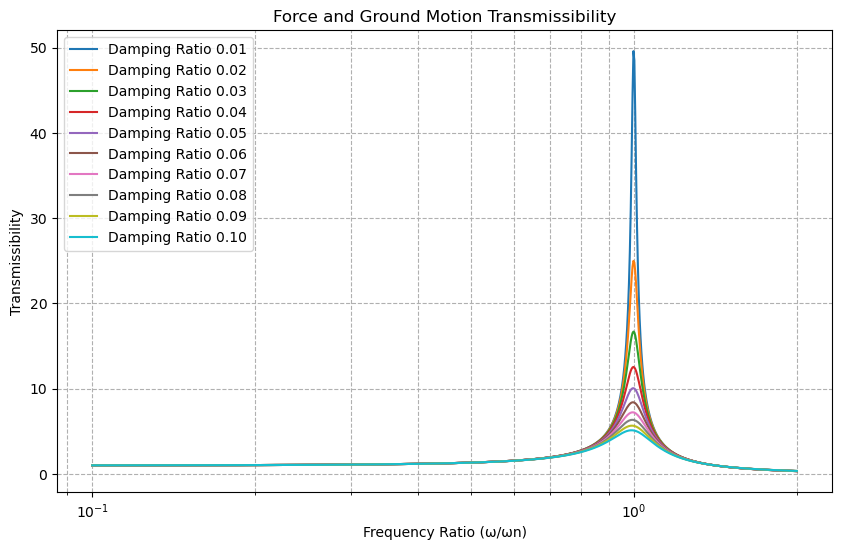

In [6]:
# Calculate and plot Transmissibility
transmissibility_force = []

for zeta in damping_ratios:
    tf = []  # Force transmissibility for this damping ratio
    for r in frequency_ratios:
        numerator = 1 + (2 * zeta * r)**2
        denominator = (1 - r**2)**2 + (2 * zeta * r)**2
        tf.append(np.sqrt(numerator / denominator))
    transmissibility_force.append(tf)

# Plot Transmissibility
plt.figure(figsize=(10, 6))

for i, zeta in enumerate(damping_ratios):
    plt.semilogx(frequency_ratios, transmissibility_force[i], label=f'Damping Ratio {zeta:.2f}')

plt.title('Force and Ground Motion Transmissibility')
plt.xlabel('Frequency Ratio (\u03c9/\u03c9n)')
plt.ylabel('Transmissibility')
plt.legend()
plt.grid(True, which="both", linestyle='--')
plt.show()